In [1]:
from astroquery.jplhorizons import Horizons
from astroquery.jplsbdb import SBDB
from astropy.table import QTable
import astropy.units as u
from astropy.time import Time

import pandas as pd
import numpy as np
import requests
from pprint import pprint
from array import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#for function import
import nbimporter
import sb_mission_design

# Define access to JPL SBDB

In [ ]:
sbdb = SBDB.query('2001VB', neo_only=True, full_precision=True, phys=True, virtual_impactor=True)
sbdb["orbit"]['elements']

In [2]:
def get_dict(name_list):
    # Return information for each bodies in name_list from JPL Small Body Database in form of dictionair
    # INPUT
    # name_list      list [name1, name2, ..., nameN]
    # OUTPUT
    # dict_bodies    dict with the following structure
    # str(name): "fullname"
    #         "our_id"                is the id inside the new dict, from 0 to N-1 where N is the name_list length
    #         "neo_flag"
    #         "orbit_class"
    #         "pha_flag"
    #         "object_kind"
    #         "moid"
    #         "orbita_elements"
    #         "condition_code"
    #         "rms"
    #         "orbit_comment"
    #         "magn_radius_flag"      is "H" if the next parameter is the magnitude, is "D" if the next parameter is the diameter
    #         "H" or "D"
    #         "spectral_category_flag"     T, S or 0
    #         "spectral_category"
    #         "N_obs"                      Number of observations
    #         "obs_span"                   Time between first and last observation
    #         "impacts": str(impact id):   'width'  
    #                                      'energy'
    #                                      'stretch'
    #                                      'ip'
    #                                      'dt'
    #                                      'date'
    #                                      'sigma_lov'
    #                                      'h'
    #                                      'mass'
    #                                      'v_inf'
    #                                      'sigma_imp'
    #                                      'method'
    #                                      'ts'
    #                                      'diam'
    #                                      'dist'
    #                                      'v_imp'
    #                                      'ps'
    
    our_id=0;
    dict_bodies={};

    for name in name_list:
        sbdb = SBDB.query(name, neo_only=True, full_precision=True, phys=True, virtual_impactor=True)
        if sbdb["object"]["kind"]!='cn' or sbdb["object"]["kind"]!='cu' :
            asteroid={"fullname": sbdb["object"]["fullname"],# TODO vogliamo fare un check?
              "our_id":our_id,
              "neo_flag": sbdb["object"]["neo"],
              "orbit_class":sbdb["object"]["orbit_class"]["code"],
              "pha_flag":sbdb["object"]["pha"],
              "object_kind":sbdb["object"]["kind"], #an asteroid numbered au unbered asteroid (cn, cu for comet)
              "moid": sbdb["orbit"]["moid"],
              "orbital_elements":sbdb["orbit"]['elements'],
              "condition_code": sbdb["orbit"]["condition_code"], #OCC
              "rms": sbdb["orbit"]["rms"],
              "orbit_comment":sbdb["orbit"]["comment"],
             };
            try:     
                asteroid["magn_radius_flag"]='H';
                asteroid["H"]=sbdb['phys_par']['H'];
            except:
                asteroid["magn_radius_flag"]='D';
                asteroid["D"]=sbdb['phys_par']['diameter'];
            asteroid["N_obs"]=sbdb['orbit']['n_obs_used'];
            asteroid["obs_span"]=sbdb['orbit']['data_arc'];
            
            asteroid["impacts"]={}
            flag_bool=1;
            if 'phys_par' in sbdb.keys():
                spect_flag=0;
                if 'spec_T' in sbdb['phys_par'].keys():
                    asteroid["spectral_category_flag"]='T'
                    asteroid["spectral_category"]=sbdb['phys_par']['spec_T']
                    spect_flag=1;
                if 'spec_B' in sbdb['phys_par'].keys():
                    asteroid["spectral_category_flag"]='B'
                    asteroid["spectral_category"]=sbdb['phys_par']['spec_B']
                    spect_flag=1;
                if spect_flag==0:
                    asteroid["spectral_category_flag"]='0'
            else:
                asteroid["spectral_category"]='0'
                
            if 'ip' in sbdb["vi_data"]:
                n_imp=len(sbdb["vi_data"]['ip']);
                for key in sbdb["vi_data"].keys():
                    if flag_bool==1:
                        for i in range(0,n_imp):
                            asteroid["impacts"][str(i)]={};
                        flag_bool=0;
                    for i in range(0,n_imp): 
                        try:
                            if isinstance(sbdb["vi_data"][key],str):
                                asteroid["impacts"][str(i)][key]=sbdb["vi_data"][key];
                            else:
                                asteroid["impacts"][str(i)][key]=sbdb["vi_data"][key][i];
                        except:
                            pprint(name+" could raise error in importing virtual impact data") #this exception is raised if only one impact is present
            dict_bodies[name]=asteroid;
            our_id=our_id+1;
            flag_bool=1;
            del asteroid;
    return dict_bodies
        

# Extract ESA risk list

In [3]:
def extract_esa_name_from_file(file_name):
    f = open(file_name, "r")
    line=f.readline()
    line=f.readline()
    line=f.readline()
    line=f.readline()
    counter=0;
    esa_names=[]
    for line in f:
        word="";
        for c in line:
            if c==' ':
                break;
            else:
                word=word+c;
        esa_names.append(word);  
    return esa_names

In [4]:
esa_risk_names=extract_esa_name_from_file("esa_risk_list.txt");

# Extract SENTRY risk list

In [5]:
def get_sentry_risk_list():
    url = 'https://ssd-api.jpl.nasa.gov/sentry.api'
    r = requests.get(url)
    data = r.json()
    sentry_risk_names=[];
    for i in range(0,len(data['data'])):
        name_=""
        name=data['data'][i]['des'];
        for c in name:
            if c==' ':
                a=0;
            else:
                name_=name_+c;
        sentry_risk_names.append(name_)
    return sentry_risk_names


In [6]:
sentry_risk_names=get_sentry_risk_list()

# Merge risk lists

In [7]:
risk_list=esa_risk_names;
counter=0;
for risk_name in sentry_risk_names:
    if risk_name not in esa_risk_names:
        risk_list.append(risk_name)

# Query SBDB for all risk list elements

In [8]:
dict_risk_list=get_dict(risk_list);

'29075 could raise error in importing virtual impact data'


# DB visualization

# MOID & H

In [ ]:
H_=[];
MOID_=[];
for key in dict_risk_list:
    try:
        H_.append(dict_risk_list[key]['H']);
        MOID_.append(dict_risk_list[key]['moid'].scale)
    except:
        pprint(key+' does not have magnitude info')
x = MOID_
y = H_
fig, ax = plt.subplots()
ax.plot(x,y, marker='o', linewidth=0)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(-14, 306, 20))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.show()

# H and Orbit Condition Code

In [ ]:
H_=[];
OCC_=[];
for key in dict_risk_list:
    try:
        H_.append(dict_risk_list[key]['H']);
        OCC_.append(int(dict_risk_list[key]['condition_code']))
    except:
        pprint(key+' does not have magnitude info')
x = OCC_
y = H_
fig, ax = plt.subplots()
ax.plot(x,y, marker='o', linewidth=0)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(-14, 306, 20))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.show()

# Number of Observations and Orbit Condition Code

In [ ]:
nobs=[];
OCC_=[];
for key in dict_risk_list:
    try:
        nobs.append(dict_risk_list[key]['N_obs']);
        OCC_.append(int(dict_risk_list[key]['condition_code']))
    except:
        pprint(key+' does not have magnitude info')
x = OCC_
y = nobs
fig, ax = plt.subplots()
ax.plot(x,y, marker='o', linewidth=0)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(-14, 306, 20))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.show()

# List only asteroids with known spectral type

In [9]:
spectral_known=[];
for key in dict_risk_list.keys():
    if (dict_risk_list[key]['spectral_category_flag']=="B") or (dict_risk_list[key]['spectral_category_flag']=="T"):
        spectral_known.append('key');
        pprint(key)

'101955'


# Requirements filter

# MOID<=0.05au, H<=26 (if H is not available diameter>=200m)

In [10]:
MOID_H_selected=[];
for key in dict_risk_list.keys():
    if float(dict_risk_list[key]['moid'].scale)<=0.05: #MOID<=0.05 AU
        if (dict_risk_list[key]["magn_radius_flag"]=='H' and float(dict_risk_list[key]["H"])<=26) or (dict_risk_list[key]["magn_radius_flag"]=='D' and float(dict_risk_list[key]["D"])>=200):
            MOID_H_selected.append(key)

# At least one impact 2026<year<2048 with a Palermo Scale>=-7

In [11]:
date_selected=[];
PS_date_selected=[]
for key in dict_risk_list.keys():
    if '0' in dict_risk_list[key]['impacts'].keys():
        max_P=-100;
        date_flag=0;
        for imp_id in dict_risk_list[key]['impacts'].keys():
            word='';
            for c in dict_risk_list[key]['impacts'][imp_id]['date']:
                #pprint(c)
                if c=='-':
                    break;
                else:
                    word=word+c;
            if int(word)<2048 and int(word)>2026:
                date_flag=1;
                if float(dict_risk_list[key]['impacts'][imp_id]['ps'])>max_P:
                    max_P=float(dict_risk_list[key]['impacts'][imp_id]['ps']);
        if date_flag==1:
            date_selected.append(key)
            if max_P>=-7:
                PS_date_selected.append(key)
        dict_risk_list[key]["PS"]=max_P;        

# Orbit Uncertantains filter (number of observation>=40)

In [12]:
OU_selected=[];
for key in dict_risk_list:
        if int(dict_risk_list[key]['N_obs'])>=40:
            OU_selected.append(key)

# Intersect filtered lists

In [13]:
refined_selected=list(set(list(set(PS_date_selected) & set(MOID_H_selected))) & set(OU_selected))

# REPORT RESULTS:

In [ ]:
pprint('on date and PS:')
pprint(PS_date_selected)
pprint('on MOID and H:')
pprint(MOID_H_selected)
pprint('refined search:')
pprint(refined_selected)

# Exploration of results

In [ ]:
i=0
refined_dict={}
PS_list=[]
for selected in refined_selected:            
            PS_list.append(dict_risk_list[selected]['PS'])

In [ ]:
index_list=[i[0] for i in sorted(enumerate(PS_list), key=lambda x:x[1])]
index_list.reverse()
for ind in index_list:
    pprint(refined_selected[ind])
    pprint('Max Palermo Scale:' + str(PS_list[ind]))
    pprint('OCC:' + str(dict_risk_list[refined_selected[ind]]['condition_code']))

# Mission Design - Convenient target and Risk list compared

In [ ]:
years = ','.join(map(str, np.linspace(2021,2048,2048-2021+1,dtype=int)))
data = sb_mission_design.get_accessible_sb(20,3,years,'neo',False,0,1,0)

In [ ]:
nasa_A_list=[];
for i in range(len(data['data'])):
    for j in range(len(data['data'][i])):
        if j==0:
            name="";
            for c in data['data'][i][j]:
                if c!='(' and c!=')' and c!=' ':
                    name=name+c;        
            nasa_A_list.append(name);
            
            
            


In [ ]:
convenient_risk_list=list(set(nasa_A_list) & set(risk_list))
pprint(nasa_A_list)
for risk in convenient_risk_list:
    pprint(risk+' '+str(dict_risk_list[risk]['PS']))
convenient_risk_list

# Mission Design - Transfer arc analysis for Refined Risk List 

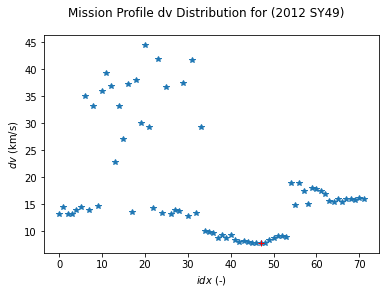

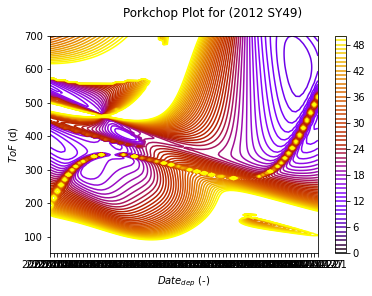

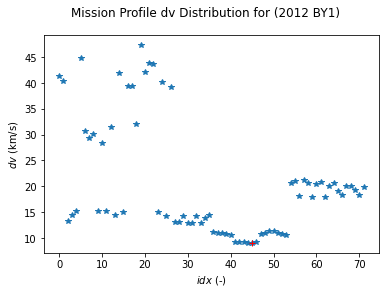

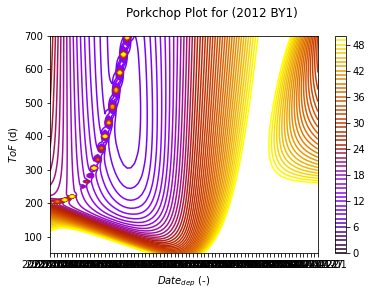

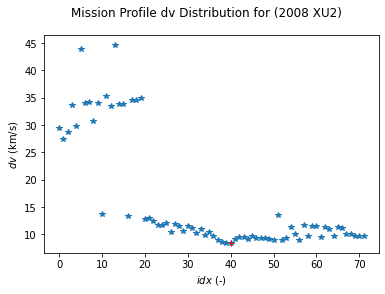

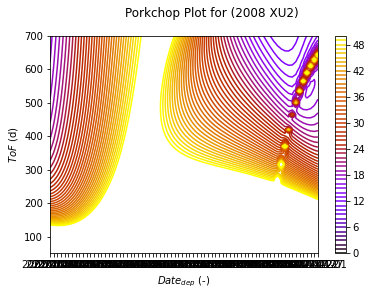

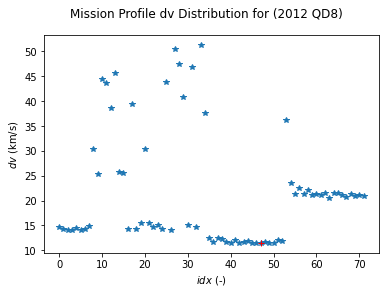

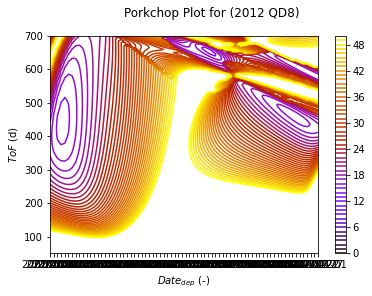

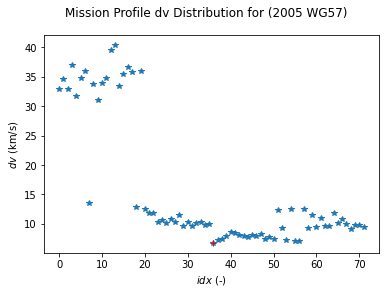

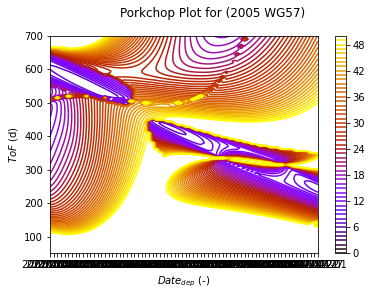

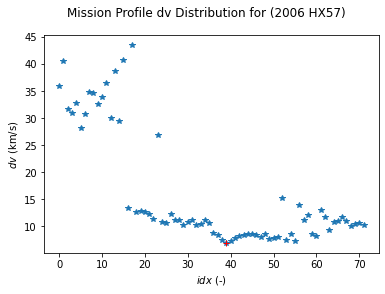

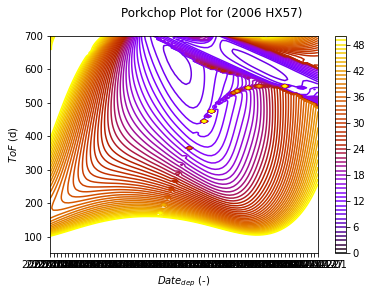

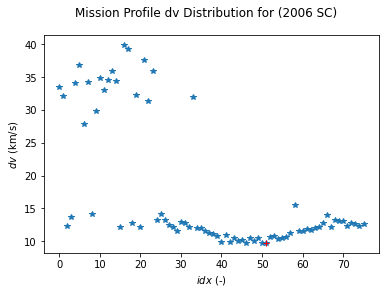

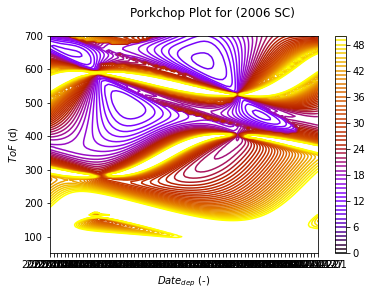

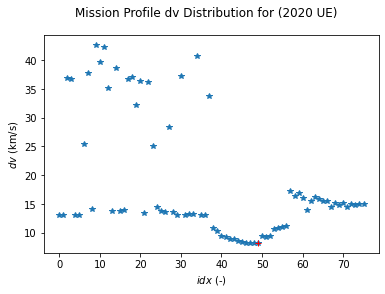

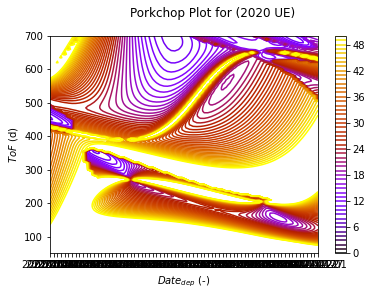

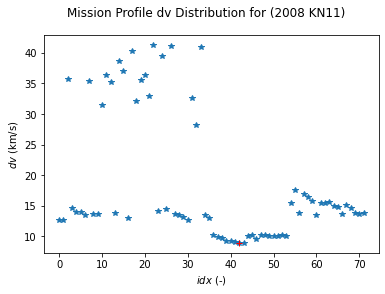

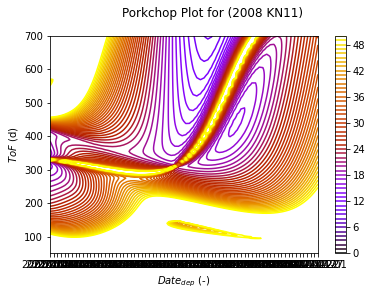

In [19]:
refined_selected_MD={};
for name in refined_selected:
    req_mjd0 = 59215
    req_duration = 365
    req_min_tof = 50
    req_max_tof = 700
    req_step_size = 5
    refined_selected_MD[name]={};
    refined_selected_MD[name]['missions'], refined_selected_MD[name]['porkchop_dv'], refined_selected_MD[name]['dep_date'], refined_selected_MD[name]['tof'], refined_selected_MD[name]['pc_plot'], refined_selected_MD[name]['mp_min_dv'], refined_selected_MD[name]['mp_dv_plot'] = \
        sb_mission_design.get_mission_profiles(name,req_mjd0,req_duration,req_min_tof,req_max_tof,req_step_size)

In [ ]:
refined_selected_MD.keys()

# Feature extraction of selected list

In [15]:
asteroids = ['2012QD8','2005WG57','2012BY1','2012SY49','2008XU2','2008KN11','2020UE','2006HX57','2006SC']
dict_risk_list=get_dict(asteroids)

In [16]:
orb_class=[]; moid=[]; occ=[]; rms=[]; H=[]; N_obs=[]; worse_impact_ps=[]; worse_impact_date=[]; worse_impact_sigma_lov=[];
idx = 0
for el in dict_risk_list:
    dict_risk_list
    orb_class.insert(idx, dict_risk_list[asteroids[idx]]['orbit_class'])
    moid.insert(idx, dict_risk_list[asteroids[idx]]['moid'])
    occ.insert(idx, dict_risk_list[asteroids[idx]]['condition_code'])
    rms.insert(idx, dict_risk_list[asteroids[idx]]['rms'])
    H.insert(idx, dict_risk_list[asteroids[idx]]['H'])
    N_obs.insert(idx, dict_risk_list[asteroids[idx]]['N_obs'])
    worse_impact_ps_lim = -999
    worse_impact_ps.insert(idx, worse_impact_ps_lim)
    worse_impact_date_lim = '2048-01-01'
    worse_impact_date.insert(idx, worse_impact_ps_lim)
    # Sigma LOV is a measure of how well the impacting orbit fits the available observations.
    # It is equal to zero for the best-fitting (nominal) orbit while orbits with values between -3 and +3 (“3-sigma”) 
    # comprise about 99% of the virtual asteroid swarm
    worse_impact_sigma_lov_lim = -33
    worse_impact_sigma_lov.insert(idx, worse_impact_sigma_lov_lim)
    for i in range(len(dict_risk_list[asteroids[idx]]['impacts'])):
        if (dict_risk_list[asteroids[idx]]['impacts'][str(i)]['ps'] > worse_impact_ps_lim and dict_risk_list[asteroids[idx]]['impacts'][str(i)]['date'] < worse_impact_date_lim):
            worse_impact_ps.pop(idx)
            worse_impact_ps.insert(idx, dict_risk_list[asteroids[idx]]['impacts'][str(i)]['ps'])
            worse_impact_date.pop(idx)
            worse_impact_date.insert(idx, dict_risk_list[asteroids[idx]]['impacts'][str(i)]['date'])
            worse_impact_sigma_lov.pop(idx)
            worse_impact_sigma_lov.insert(idx, dict_risk_list[asteroids[idx]]['impacts'][str(i)]['sigma_lov'])
            
            worse_impact_ps_lim = dict_risk_list[asteroids[idx]]['impacts'][str(i)]['ps']     
            
    idx = idx + 1

In [17]:
t = QTable([asteroids,orb_class,moid,occ,rms,H,N_obs,worse_impact_ps,worse_impact_date,worse_impact_sigma_lov],
           names=('name','orb_class','moid','occ','rms','H','N_obs','worse_impact_ps','worse_impact_date','worse_impact_sigma_lov'),
           meta={'name': 'data table'});

t.show_in_notebook()

idx,name,orb_class,moid,occ,rms,H,N_obs,worse_impact_ps,worse_impact_date,worse_impact_sigma_lov
0,2012QD8,APO,0.00204637 AU,7,.32969,23.1,41,-3.88,2047-03-08.97,0.07979
1,2005WG57,APO,0.00174338 AU,7,.44121,23.6,74,-5.46,2029-08-21.18,-2.91372
2,2012BY1,APO,0.00265346 AU,8,.21663,25.7,43,-5.56,2043-01-25.70,-0.70829
3,2012SY49,APO,0.000121773 AU,7,.33057,25.8,43,-6.13,2042-09-29.17,-0.30579
4,2008XU2,APO,0.00227454 AU,7,.42338,25.6,44,-6.23,2039-11-25.06,1.19599
5,2008KN11,APO,0.00100506 AU,7,.43494,23.2,132,-6.26,2046-06-20.80,2.54854
6,2020UE,APO,0.000806548 AU,6,.25849,25.5,132,-6.34,2042-10-16.10,1.31809
7,2006HX57,APO,0.00153463 AU,7,.46289,25.2,84,-6.82,2045-05-09.08,2.1686
8,2006SC,APO,0.000519363 AU,6,.55666,25.1,107,-6.89,2043-09-14.09,-2.12185
